# Models

## distilbert-base-uncased-finetuned-sst-2-english

distilbert-base-uncased-finetuned-sst-2-english
Binary sentiment (POSITIVE / NEGATIVE)
https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

## SamLowe/roberta-base-go_emotions	

SamLowe/roberta-base-go_emotions	
28 fine-grained emotions (admiration → worry)
https://huggingface.co/SamLowe/roberta-base-go_emotions

## unitary/unbiased-toxic-roberta	

unitary/unbiased-toxic-roberta	

Toxicity & six sub-types (toxic, severe_toxic, obscene, etc.)


https://huggingface.co/unitary/unbiased-toxic-roberta

## Hate-speech-CNERG/dehatebert-mono-english

Hate-speech-CNERG/dehatebert-mono-english
Hate / non-hate
https://huggingface.co/Hate-speech-CNERG/dehatebert-mono-english

## classla/multilingual-IPTC-news-topic-classifier

classla/multilingual-IPTC-news-topic-classifier

205 IPTC NewsCodes topics (e.g., crime, culture, health)

https://huggingface.co/classla/multilingual-IPTC-news-topic-classifier

# Prerequisites

In [1]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [2]:
# pip install transformers datasets evaluate bitsandbytes accelerate peft

Check that CUDA is enabled

In [3]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available in PyTorch: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

PyTorch version: 2.7.0+cu128
CUDA available in PyTorch: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 3060


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Chosen model

distilbert-base-uncased-finetuned-sst-2-english

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

ds = load_dataset("go_emotions", "simplified")

tok_r = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
mdl_r = AutoModelForSequenceClassification.from_pretrained(
            "SamLowe/roberta-base-go_emotions").to("cuda")

clf = pipeline("text-classification",
               model=mdl_r, tokenizer=tok_r,
               device=0, batch_size=32, top_k=None)

def predict_split(split):
    out = clf(split["text"])
    return [{d["label"]: d["score"] for d in row} for row in out]

valid_logits  = predict_split(ds["validation"])
test_logits   = predict_split(ds["test"])
ds["validation"] = ds["validation"].add_column("roberta_logits", valid_logits)
ds["test"]       = ds["test"].add_column("roberta_logits",  test_logits)


c:\nextcloud\Studia - PW\semestr 6\warsztaty_badawcze\llm-workshop\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


In [6]:
print(ds['train'][0])

{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


In [65]:
print(ds["train"])

Dataset({
    features: ['text', 'labels', 'id', 'roberta_logits'],
    num_rows: 43410
})


In [66]:
emotion_cols = [col for col in ds["train"].columns if col != 'input_text']

AttributeError: 'Dataset' object has no attribute 'columns'

Available splits: ['train', 'validation', 'test']
Emotions found in train: 28 unique emotions
Emotions found in validation: 28 unique emotions
Emotions found in test: 28 unique emotions
Total emotion instances: 63812
Number of unique emotions: 28
Most frequent emotion: neutral (17772 instances)
Least frequent emotion: grief (96 instances)

All emotion counts:
  neutral: 17772
  admiration: 5122
  approval: 3687
  gratitude: 3372
  annoyance: 3093
  amusement: 2895
  curiosity: 2723
  disapproval: 2581
  love: 2576
  optimism: 1976
  anger: 1960
  joy: 1785
  confusion: 1673
  sadness: 1625
  disappointment: 1583
  realization: 1382
  caring: 1375
  surprise: 1330
  excitement: 1052
  disgust: 1013
  desire: 801
  fear: 764
  remorse: 669
  embarrassment: 375
  nervousness: 208
  relief: 182
  pride: 142
  grief: 96


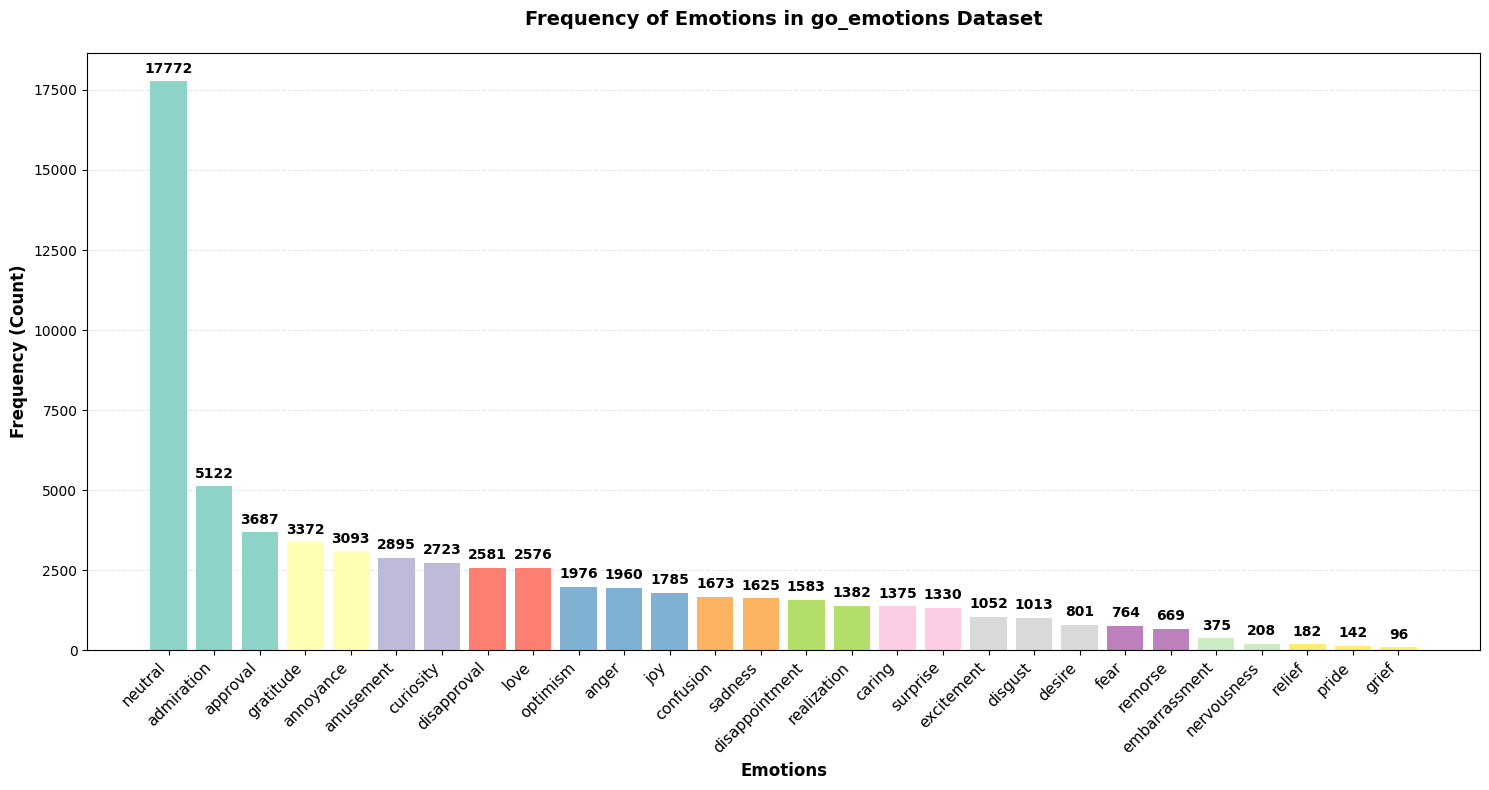

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

def plot_emotion_frequencies(ds, splits=['train', 'validation', 'test'], figsize=(12, 6)):
    print(f"Available splits: {list(ds.keys())}")
    
    first_split = list(ds.keys())[0]
    if 'labels' in ds[first_split].features:
        labels_feature = ds[first_split].features['labels']
        if hasattr(labels_feature, 'feature') and hasattr(labels_feature.feature, 'names'):
            emotion_names = labels_feature.feature.names
        elif hasattr(labels_feature, 'names'):
            emotion_names = labels_feature.names
        else:
            for i in range(min(5, len(ds[first_split]))):
                print(f"Example {i}: {ds[first_split][i]['labels']}")
            return None, None, None
    else:
        print("No 'labels' feature found!")
        return None, None, None
    
    
    emotion_counts = Counter()
    
    for split_name in splits:
        if split_name in ds:
            split_data = ds[split_name]
            for i in range(min(3, len(split_data))):
                labels = split_data[i]['labels']
                if isinstance(labels, list):
                    active_emotions = [emotion_names[idx] for idx in labels if 0 <= idx < len(emotion_names)]
            
            for sample_idx, labels in enumerate(split_data['labels']):
                if isinstance(labels, list):
                    for emotion_idx in labels:
                        if 0 <= emotion_idx < len(emotion_names):
                            emotion_counts[emotion_names[emotion_idx]] += 1
                        elif sample_idx < 5: 
                            print(f"Warning: Invalid emotion index {emotion_idx} in sample {sample_idx}")
                elif sample_idx < 5:
                    print(f"Warning: Unexpected label format in sample {sample_idx}: {labels}")
            
            print(f"Emotions found in {split_name}: {len([k for k, v in emotion_counts.items() if v > 0])} unique emotions")
    
    if not emotion_counts:
        print("No emotions found! Check your dataset structure.")
        return None, None, None
    
    sorted_emotions = sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)
    emotions, counts = zip(*sorted_emotions)
    figsize = (15, 8)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(emotions)))
    bars = ax.bar(range(len(emotions)), counts, color=colors)
    
    ax.set_xlabel('Emotions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency (Count)', fontsize=12, fontweight='bold')
    ax.set_title('Frequency of Emotions in go_emotions Dataset', fontsize=14, fontweight='bold', pad=20)
    
    ax.set_xticks(range(len(emotions)))
    ax.set_xticklabels(emotions, rotation=45, ha='right', fontsize=11)
    
    for i, (bar, count) in enumerate(zip(bars, counts)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    plt.tight_layout()
    total_samples = sum(counts)
    print(f"Total emotion instances: {total_samples}")
    print(f"Number of unique emotions: {len(emotions)}")
    print(f"Most frequent emotion: {emotions[0]} ({counts[0]} instances)")
    print(f"Least frequent emotion: {emotions[-1]} ({counts[-1]} instances)")
    
    print(f"\nAll emotion counts:")
    for emotion, count in sorted_emotions:
        print(f"  {emotion}: {count}")
    
    return fig, ax, dict(sorted_emotions)

fig, ax, emotion_dict = plot_emotion_frequencies(ds)
plt.show()


Found 1452 samples with emotion 'joy'


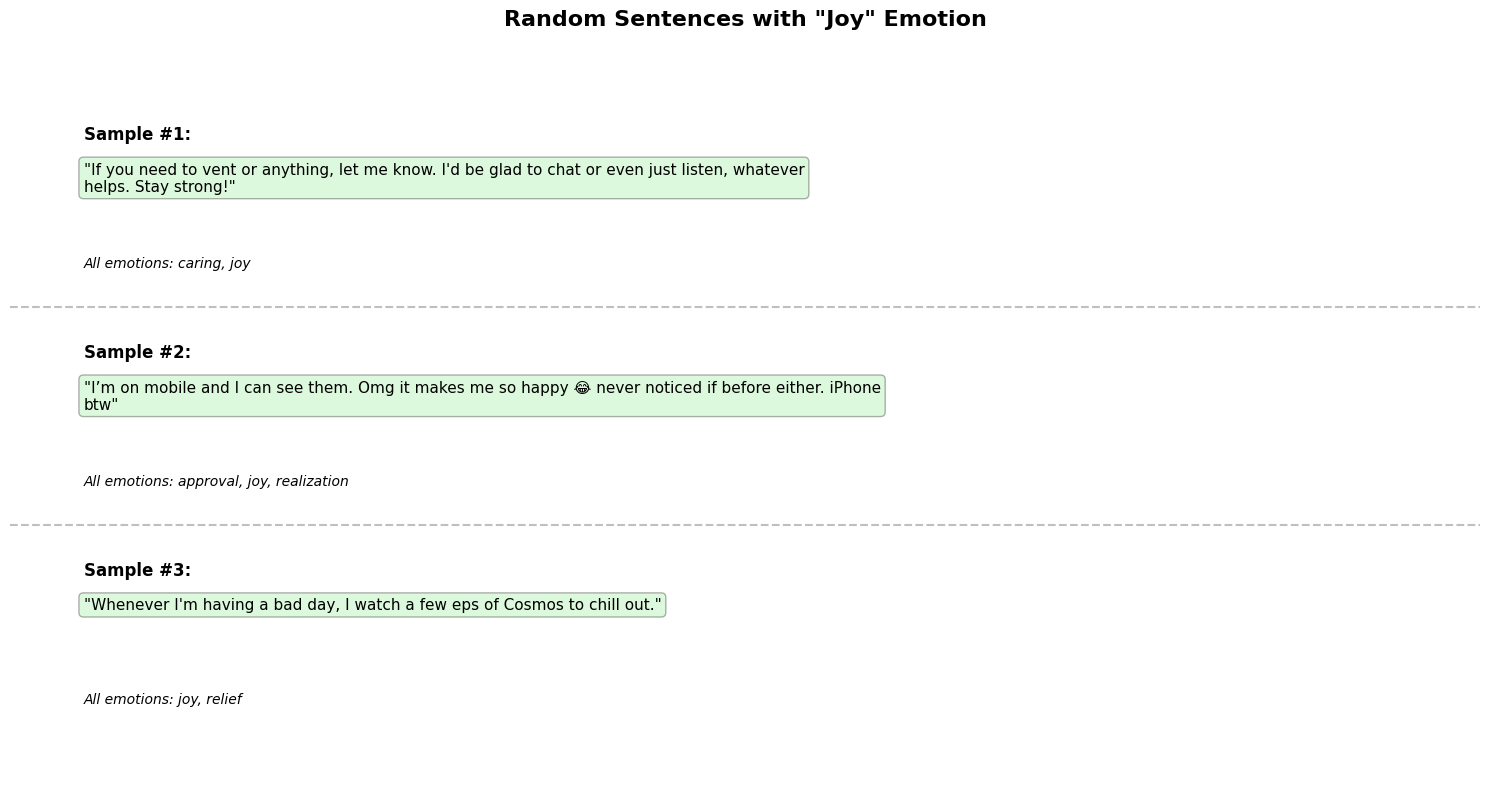

In [90]:
import random
import textwrap
def plot_sentences_by_emotion(ds, emotion_name, split='train', n_samples=3, figsize=(15, 8), seed=42):
    random.seed(seed)
    emotion_names = ds[split].features['labels'].feature.names
    
    if emotion_name not in emotion_names:
        print(f"Emotion '{emotion_name}' not found. Available emotions:")
        print(emotion_names)
        return None, None
    
    emotion_idx = emotion_names.index(emotion_name)
    
    split_data = ds[split]
    matching_samples = []
    
    for i, sample in enumerate(split_data):
        if emotion_idx in sample['labels']:
            matching_samples.append(i)
    
    if not matching_samples:
        print(f"No samples found with emotion '{emotion_name}'")
        return None, None
    
    print(f"Found {len(matching_samples)} samples with emotion '{emotion_name}'")
    
    selected_samples = random.sample(matching_samples, min(n_samples, len(matching_samples)))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, n_samples * 3 + 1)
    ax.axis('off')
    
    ax.set_title(f'Random Sentences with "{emotion_name.title()}" Emotion', 
                 fontsize=16, fontweight='bold', pad=20)
    
    for i, sample_idx in enumerate(selected_samples):
        sample = split_data[sample_idx]
        text = sample['text']
        label_indices = sample['labels']
        active_emotions = [emotion_names[idx] for idx in label_indices if 0 <= idx < len(emotion_names)]
        
        y_base = n_samples * 3 - i * 3
        wrapped_text = textwrap.fill(text, width=100)
        
        ax.text(0.5, y_base, f'Sample #{i+1}:', fontsize=12, fontweight='bold', ha='left', va='top')
        ax.text(0.5, y_base - 0.5, f'"{wrapped_text}"', fontsize=11, ha='left', va='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.3))
        ax.text(0.5, y_base - 1.8, f'All emotions: {", ".join(active_emotions)}', 
                fontsize=10, ha='left', va='top', style='italic')
        if i < len(selected_samples) - 1:
            ax.axhline(y=y_base - 2.5, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    return fig, ax

fig, ax = plot_sentences_by_emotion(ds, 'joy', split='train', n_samples=3)
plt.show()

# Creating the train data set

In [7]:
import pandas as pd
import numpy as np
from datasets import Dataset
from tqdm import tqdm


In [8]:
emotion_labels = ds["validation"].features["labels"].feature.names

In [9]:
def create_emotion_probabilities_df(dataset_split):
    texts = []
    emotion_probs = {emotion: [] for emotion in emotion_labels}
    
    for text, roberta_logits in zip(dataset_split["text"], dataset_split["roberta_logits"]):
        texts.append(text)
        
        for emotion in emotion_labels:
            prob = roberta_logits.get(emotion, 0.0)
            emotion_probs[emotion].append(prob)
    
    df_data = {'input_text': texts}
    df_data.update(emotion_probs)
    
    df = pd.DataFrame(df_data)
    return df

def predict_with_dataset_optimized(dataset_split, batch_size=128):
    texts = dataset_split["text"]
    temp_dataset = Dataset.from_dict({"text": texts})
    
    def predict_batch(batch):
        try:
            outputs = clf(batch["text"], truncation=True, max_length=512)
            predictions = [{d["label"]: d["score"] for d in row} for row in outputs]
            return {"roberta_logits": predictions}
        except Exception as e:
            empty_preds = [{label: 0.0 for label in emotion_labels} for _ in range(len(batch["text"]))]
            return {"roberta_logits": empty_preds}
    
    result_dataset = temp_dataset.map(
        predict_batch,
        batched=True,
        batch_size=batch_size,
        remove_columns=["text"]
    )
    
    predictions = result_dataset["roberta_logits"]
    return predictions

def predict_with_dataset_progress(dataset_split, batch_size=128):
    texts = dataset_split["text"]
    total_samples = len(texts)
    chunk_size = 5000
    all_predictions = []
    
    for start_idx in tqdm(range(0, total_samples, chunk_size)):
        end_idx = min(start_idx + chunk_size, total_samples)
        chunk_texts = texts[start_idx:end_idx]
        
        chunk_dataset = Dataset.from_dict({"text": chunk_texts})
        
        def predict_batch(batch):
            outputs = clf(batch["text"], truncation=True, max_length=512)
            return {"roberta_logits": [{d["label"]: d["score"] for d in row} for row in outputs]}
        
        chunk_result = chunk_dataset.map(
            predict_batch,
            batched=True,
            batch_size=batch_size,
            remove_columns=["text"]
        )
        
        all_predictions.extend(chunk_result["roberta_logits"])
    
    return all_predictions

if 'roberta_logits' not in ds['train'].column_names:
    try:
        train_logits = predict_with_dataset_optimized(ds["train"], batch_size=128)
    except Exception as e:
        train_logits = predict_with_dataset_progress(ds["train"], batch_size=64)
    
    ds["train"] = ds["train"].add_column("roberta_logits", train_logits)

train_df = create_emotion_probabilities_df(ds["train"])
validation_df = create_emotion_probabilities_df(ds["validation"])
test_df = create_emotion_probabilities_df(ds["test"])

Map: 100%|██████████| 43410/43410 [01:01<00:00, 704.58 examples/s]


In [10]:
train_df = create_emotion_probabilities_df(ds["train"])

In [11]:
train_df

,input_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0.161234,0.001972,0.001539,0.004159,0.233412,0.001775,0.001889,0.001202,0.002167,...,0.421444,0.000364,0.002896,0.003201,0.013179,0.002387,0.000306,0.000815,0.001866,0.100186
1,"Now if he does off himself, everyone will thin...",0.000930,0.134094,0.003719,0.026139,0.011867,0.001842,0.001364,0.000668,0.001538,...,0.000506,0.000549,0.006830,0.000483,0.013376,0.000889,0.000497,0.001741,0.000749,0.840025
2,WHY THE FUCK IS BAYLESS ISOING,0.005290,0.004081,0.781201,0.122706,0.003216,0.001910,0.008621,0.012958,0.001135,...,0.002823,0.000530,0.002151,0.000427,0.002942,0.000247,0.000637,0.004392,0.005214,0.105964
3,To make her feel threatened,0.001722,0.001781,0.006446,0.019079,0.008645,0.030293,0.001861,0.001075,0.004182,...,0.000735,0.035958,0.008934,0.000745,0.008453,0.002275,0.001704,0.028242,0.001346,0.596796
4,Dirty Southern Wankers,0.004310,0.002896,0.484007,0.412610,0.006365,0.001364,0.001875,0.001695,0.001533,...,0.001446,0.000364,0.001642,0.000530,0.003438,0.000259,0.000684,0.003494,0.001129,0.081161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,0.026941,0.007407,0.003022,0.004451,0.044037,0.006570,0.002259,0.001861,0.009586,...,0.879727,0.001147,0.008405,0.001667,0.006569,0.003192,0.001235,0.004176,0.002155,0.018019
43406,Always thought that was funny but is it a refe...,0.003609,0.134665,0.002364,0.011986,0.016143,0.002777,0.742798,0.473192,0.002103,...,0.005241,0.004450,0.009182,0.000210,0.046299,0.001058,0.002461,0.003309,0.015203,0.048970
43407,What are you talking about? Anything bad that ...,0.001845,0.000994,0.022686,0.173971,0.018671,0.005762,0.177501,0.349683,0.001740,...,0.001105,0.004448,0.005316,0.000227,0.014244,0.000642,0.007382,0.026744,0.003809,0.205243
43408,"More like a baptism, with sexy results!",0.218485,0.005374,0.001724,0.003316,0.053343,0.000947,0.001491,0.002307,0.003576,...,0.014900,0.001004,0.004851,0.010119,0.007214,0.002234,0.000232,0.000925,0.018660,0.136118


In [12]:
train_df.columns

Index(['input_text', 'admiration', 'amusement', 'anger', 'annoyance',
       'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral'],
      dtype='object')

In [13]:
emotion_cols = train_df.columns.drop("input_text")
emotion_values = train_df[emotion_cols].values
emotion_values

array([[1.61234200e-01, 1.97226345e-03, 1.53873081e-03, ...,
        8.14727973e-04, 1.86631945e-03, 1.00186482e-01],
       [9.29759583e-04, 1.34094074e-01, 3.71863181e-03, ...,
        1.74149009e-03, 7.48839928e-04, 8.40024650e-01],
       [5.29006822e-03, 4.08113888e-03, 7.81201065e-01, ...,
        4.39203624e-03, 5.21371607e-03, 1.05963692e-01],
       ...,
       [1.84532825e-03, 9.93798836e-04, 2.26864778e-02, ...,
        2.67438944e-02, 3.80882295e-03, 2.05242589e-01],
       [2.18485102e-01, 5.37432684e-03, 1.72380323e-03, ...,
        9.24984226e-04, 1.86597891e-02, 1.36117727e-01],
       [2.28378270e-02, 7.70451725e-02, 2.98157847e-03, ...,
        3.63864470e-03, 1.18638168e-03, 3.58057767e-02]],
      shape=(43410, 28))

In [14]:

top_3_indices = np.argpartition(emotion_values, -3, axis=1)[:, -3:]
top_3_sorted = np.take_along_axis(top_3_indices,
                                  np.argsort(np.take_along_axis(emotion_values, top_3_indices, axis=1), axis=1)[:, ::-1],
                                  axis=1)
train_df['emotion_1'] = [emotion_cols[idx] for idx in top_3_sorted[:, 0]]
train_df['emotion_2'] = [emotion_cols[idx] for idx in top_3_sorted[:, 1]]
train_df['emotion_3'] = [emotion_cols[idx] for idx in top_3_sorted[:, 2]]

train_df['emotion_1_value'] = emotion_values[np.arange(len(emotion_values)), top_3_sorted[:, 0]]
train_df['emotion_2_value'] = emotion_values[np.arange(len(emotion_values)), top_3_sorted[:, 1]]
train_df['emotion_3_value'] = emotion_values[np.arange(len(emotion_values)), top_3_sorted[:, 2]]

In [15]:
train_df

,input_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,remorse,sadness,surprise,neutral,emotion_1,emotion_2,emotion_3,emotion_1_value,emotion_2_value,emotion_3_value
0,My favourite food is anything I didn't have to...,0.161234,0.001972,0.001539,0.004159,0.233412,0.001775,0.001889,0.001202,0.002167,...,0.000306,0.000815,0.001866,0.100186,love,approval,admiration,0.421444,0.233412,0.161234
1,"Now if he does off himself, everyone will thin...",0.000930,0.134094,0.003719,0.026139,0.011867,0.001842,0.001364,0.000668,0.001538,...,0.000497,0.001741,0.000749,0.840025,neutral,amusement,annoyance,0.840025,0.134094,0.026139
2,WHY THE FUCK IS BAYLESS ISOING,0.005290,0.004081,0.781201,0.122706,0.003216,0.001910,0.008621,0.012958,0.001135,...,0.000637,0.004392,0.005214,0.105964,anger,annoyance,neutral,0.781201,0.122706,0.105964
3,To make her feel threatened,0.001722,0.001781,0.006446,0.019079,0.008645,0.030293,0.001861,0.001075,0.004182,...,0.001704,0.028242,0.001346,0.596796,neutral,fear,nervousness,0.596796,0.246723,0.035958
4,Dirty Southern Wankers,0.004310,0.002896,0.484007,0.412610,0.006365,0.001364,0.001875,0.001695,0.001533,...,0.000684,0.003494,0.001129,0.081161,anger,annoyance,disgust,0.484007,0.412610,0.108915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,0.026941,0.007407,0.003022,0.004451,0.044037,0.006570,0.002259,0.001861,0.009586,...,0.001235,0.004176,0.002155,0.018019,love,joy,approval,0.879727,0.427309,0.044037
43406,Always thought that was funny but is it a refe...,0.003609,0.134665,0.002364,0.011986,0.016143,0.002777,0.742798,0.473192,0.002103,...,0.002461,0.003309,0.015203,0.048970,confusion,curiosity,amusement,0.742798,0.473192,0.134665
43407,What are you talking about? Anything bad that ...,0.001845,0.000994,0.022686,0.173971,0.018671,0.005762,0.177501,0.349683,0.001740,...,0.007382,0.026744,0.003809,0.205243,curiosity,neutral,confusion,0.349683,0.205243,0.177501
43408,"More like a baptism, with sexy results!",0.218485,0.005374,0.001724,0.003316,0.053343,0.000947,0.001491,0.002307,0.003576,...,0.000232,0.000925,0.018660,0.136118,excitement,admiration,neutral,0.427780,0.218485,0.136118


## Clearly seperated

In [16]:
train_df_clearly_seperated = train_df.copy()

mask = (train_df_clearly_seperated['emotion_1_value'] > 0.6) & \
       (train_df_clearly_seperated['emotion_1_value'] >= 2 * train_df_clearly_seperated['emotion_2_value'])

train_df_clearly_seperated = train_df_clearly_seperated[mask]

print(f"Original dataset size: {len(train_df)}")
print(f"Filtered dataset size: {len(train_df_clearly_seperated)}")
print(f"Percentage retained: {len(train_df_clearly_seperated) / len(train_df) * 100:.2f}%")
train_df_clearly_seperated

Original dataset size: 43410
Filtered dataset size: 28243
Percentage retained: 65.06%


,input_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,remorse,sadness,surprise,neutral,emotion_1,emotion_2,emotion_3,emotion_1_value,emotion_2_value,emotion_3_value
1,"Now if he does off himself, everyone will thin...",0.000930,0.134094,0.003719,0.026139,0.011867,0.001842,0.001364,0.000668,0.001538,...,0.000497,0.001741,0.000749,0.840025,neutral,amusement,annoyance,0.840025,0.134094,0.026139
2,WHY THE FUCK IS BAYLESS ISOING,0.005290,0.004081,0.781201,0.122706,0.003216,0.001910,0.008621,0.012958,0.001135,...,0.000637,0.004392,0.005214,0.105964,anger,annoyance,neutral,0.781201,0.122706,0.105964
6,Yes I heard abt the f bombs! That has to be wh...,0.010199,0.013303,0.001450,0.003774,0.057711,0.014411,0.011663,0.042843,0.010112,...,0.002114,0.002764,0.006621,0.018133,gratitude,excitement,approval,0.891421,0.215594,0.057711
7,We need more boards and to create a bit more s...,0.013856,0.002689,0.001615,0.008555,0.036555,0.006715,0.001840,0.005422,0.722661,...,0.001109,0.002065,0.001195,0.149801,desire,neutral,optimism,0.722661,0.149801,0.137451
9,It might be linked to the trust factor of your...,0.001255,0.000969,0.001125,0.005800,0.027530,0.003146,0.013570,0.002922,0.001720,...,0.000610,0.001687,0.000640,0.951158,neutral,approval,realization,0.951158,0.027530,0.019378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43398,I thought [NAME] was dope. Never understood th...,0.003202,0.003038,0.004255,0.017288,0.020478,0.001960,0.893626,0.015791,0.001829,...,0.003401,0.003748,0.004740,0.158409,confusion,neutral,realization,0.893626,0.158409,0.060395
43399,kinda obviously satire op,0.003236,0.009259,0.002834,0.012978,0.027070,0.000671,0.001370,0.001130,0.000704,...,0.000257,0.001283,0.000898,0.940813,neutral,approval,annoyance,0.940813,0.027070,0.012978
43402,I don't know if I'm comfortable with a religio...,0.007504,0.002620,0.005351,0.021828,0.053092,0.005964,0.903833,0.019431,0.004354,...,0.005500,0.005227,0.004465,0.064450,confusion,disapproval,neutral,0.903833,0.112747,0.064450
43405,Added you mate well I’ve just got the bow and ...,0.026941,0.007407,0.003022,0.004451,0.044037,0.006570,0.002259,0.001861,0.009586,...,0.001235,0.004176,0.002155,0.018019,love,joy,approval,0.879727,0.427309,0.044037


In [17]:
train_df.columns

Index(['input_text', 'admiration', 'amusement', 'anger', 'annoyance',
       'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral', 'emotion_1', 'emotion_2', 'emotion_3',
       'emotion_1_value', 'emotion_2_value', 'emotion_3_value'],
      dtype='object')

In [18]:
input_output_df = train_df_clearly_seperated.copy()[["input_text", "emotion_1"]].rename(columns={"input_text": "input", "emotion_1": "target"}).reset_index(drop=True)
input_output_df

,input,target
0,"Now if he does off himself, everyone will thin...",neutral
1,WHY THE FUCK IS BAYLESS ISOING,anger
2,Yes I heard abt the f bombs! That has to be wh...,gratitude
3,We need more boards and to create a bit more s...,desire
4,It might be linked to the trust factor of your...,neutral
...,...,...
28238,I thought [NAME] was dope. Never understood th...,confusion
28239,kinda obviously satire op,neutral
28240,I don't know if I'm comfortable with a religio...,confusion
28241,Added you mate well I’ve just got the bow and ...,love


In [19]:
input_output_df.to_csv("clearly_seperated.csv")

## All

In [20]:
input_output_df = train_df.copy()[["input_text", "emotion_1"]].rename(columns={"input_text": "input", "emotion_1": "target"}).reset_index(drop=True)
input_output_df

,input,target
0,My favourite food is anything I didn't have to...,love
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,neutral
4,Dirty Southern Wankers,anger
...,...,...
43405,Added you mate well I’ve just got the bow and ...,love
43406,Always thought that was funny but is it a refe...,confusion
43407,What are you talking about? Anything bad that ...,curiosity
43408,"More like a baptism, with sexy results!",excitement


# Prompt engineering

In [118]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model_name = "microsoft/Phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    quantization_config=quantization_config
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.99s/it]


In [22]:
def get_model_prediction(input_text, prompt_template=None, max_new_tokens=10, do_sample=False, temperature=0.7):
    if prompt_template is None:
        prompt = f"What single concept best explains the output? Input: {input_text}"
    else:
        prompt = prompt_template.format(input_text=input_text)
   
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
   
    generation_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.eos_token_id
    }
    
    if do_sample:
        generation_kwargs["temperature"] = temperature
   
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **generation_kwargs
        )
   
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [23]:
first_10 = input_output_df.head(10).copy()
prompts = {
    "concept": "What single concept best explains the output? Input: {input_text}",
    "emotion": "What emotion does this text convey? Text: {input_text}\nEmotion:",
    "topic": "Identify the main topic of this text in one word: {input_text}\nTopic:",
    "summary": "Summarize this in one word: {input_text}\nWord:"
}

for prompt_name, prompt_template in prompts.items():
    first_10[f'pred_{prompt_name}'] = first_10['input'].apply(
        lambda x: get_model_prediction(
            x, 
            prompt_template=prompt_template,
            max_new_tokens=10,
            do_sample=prompt_name != "concept",
            temperature=0.1
        )
    )

first_10

,input,target,pred_concept,pred_emotion,pred_topic,pred_summary
0,My favourite food is anything I didn't have to...,love,Output: Autonomy. The concept of autonomy,The text conveys a sense of relief or,Culinary\n\nText: I'm,Convenience\n\nSummary: My favourite
1,"Now if he does off himself, everyone will thin...",neutral,. Output: Conspiracy. The concept of,The text conveys a sense of frustration,### Answer:\nDeception,Hypocrisy\n\n**Question:**
2,WHY THE FUCK IS BAYLESS ISOING,anger,? Output:,Anger\n\nInput:\nText: WH,Document:\n\nI'm not,Reason\n\nSummary: Bayless is leaving
3,To make her feel threatened,neutral,", she said, ""You're always so",Fear\n\nText: To make her feel,Threat\n\nInput:\n\nDocument,Intimidate\n\nInput:
4,Dirty Southern Wankers,anger,. Output:,Document:\n\nThe document is,Document:\n\nThe Dirty South,Filth\n\n**Question:**
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,neutral,# Answer\nThe single concept that best,The text conveys frustration and disappointment,Sports\n\nText:\n\nThe latest research,Broncos\n\n**Instruction:**
6,Yes I heard abt the f bombs! That has to be wh...,gratitude,����������,The text conveys a sense of relief and,Bombings\n\nInput:\n\nI',Bombs\n\nSummary: Bombs
7,We need more boards and to create a bit more s...,desire,Output:\n\nSpace optimization,Frustration\n\nInput:\nText: I,Space\n\nInput:\n\nText:,Expansion\n\nInstruction 2 (More
8,Damn youtube and outrage drama is super lucrat...,admiration,. Output: profit\n\nInput: The new,Document:\n\nThe document discuss,Reddit\n\nInput:\n\nDocument:,Profit\n\nInstruction 2 (M
9,It might be linked to the trust factor of your...,neutral,Input: The trust factor of your friend,The text conveys a sense of caution,Trust\n\nText:\n\nI'm,Trust\n\nInput:\nThe document discusses


In [24]:
grouped_samples = input_output_df.groupby('target').head(10).copy()

In [25]:
concept_prompt = "What single concept best explains the output? Input: {input_text}"

grouped_samples['concept_prediction'] = grouped_samples['input'].apply(
    lambda x: get_model_prediction(
        x,
        prompt_template=concept_prompt,
        max_new_tokens=10,
        do_sample=False
    )
)

result_df = pd.DataFrame({
    'prompt': grouped_samples['input'],
    'output': grouped_samples['concept_prediction'],
    'real_output': grouped_samples['target']
})

result_df = result_df.reset_index(drop=True)

result_df

,prompt,output,real_output
0,My favourite food is anything I didn't have to...,Output: Autonomy. The concept of autonomy,love
1,"Now if he does off himself, everyone will thin...",. Output: Conspiracy. The concept of,neutral
2,WHY THE FUCK IS BAYLESS ISOING,? Output:,anger
3,To make her feel threatened,", she said, ""You're always so",neutral
4,Dirty Southern Wankers,. Output:,anger
...,...,...,...
259,Everyone hates these posts but when we do post...,Output:\n\n\n### Answer,pride
260,I'm proud that this is the first response I see.,Output: pride\n\nInput: I'm,pride
261,Well sure his one appearance in relief lost us...,Options:\n(1). Baseball,relief
262,At least your stepdad didn't just take the pil...,Output: The concept that best explains the out...,relief


## simple tests

In [98]:
def get_simple_model_prediction(input_text, prompt_template=None, max_new_tokens=10, do_sample=False, temperature=0.7):
    prompt = input_text
   
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
   
    generation_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.eos_token_id
    }
    
    if do_sample:
        generation_kwargs["temperature"] = temperature
   
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **generation_kwargs
        )
   
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [99]:
get_simple_model_prediction("What is the author feeling from the list: 'joy' 'sadness' 'anger': 'I'm sad' ")

"The author is feeling 'sadness"

In [119]:
emotions_str = ','.join(list(emotion_dict.keys()))
long_prompt = f"What is the author feeling from the list: {emotions_str}: 'I'm sad' "
get_simple_model_prediction(long_prompt)

'Answer: The author is feeling sad.'

real example

In [127]:
sample_sentence = "your mom likes to copy me cause she has no creativity just like you:"
emotions_str = ','.join(list(emotion_dict.keys()))
long_prompt = f"What is the author feeling from the list: {emotions_str}: '{sample_sentence}' "
print("LLM prediction:", get_simple_model_prediction(long_prompt, max_new_tokens=35))
print("Model prediction: 'neutral' ")

LLM prediction: **Solution:** The author is likely feeling a mix of emotions, but the most prominent one from the list provided would be 'annoyance'. This
Model prediction: 'neutral' 


In [26]:
concept_prompt = "What single emotion best explains the what the author is feeling? Input: {input_text}"

grouped_samples['concept_prediction'] = grouped_samples['input'].apply(
    lambda x: get_model_prediction(
        x,
        prompt_template=concept_prompt,
        max_new_tokens=10,
        do_sample=False
    )
)

result_df = pd.DataFrame({
    'prompt': grouped_samples['input'],
    'output': grouped_samples['concept_prediction'],
    'real_output': grouped_samples['target']
})

result_df = result_df.reset_index(drop=True)

result_df

,prompt,output,real_output
0,My favourite food is anything I didn't have to...,Output:The single emotion that best,love
1,"Now if he does off himself, everyone will thin...",.\n\nOutput:The author is feeling fr,neutral
2,WHY THE FUCK IS BAYLESS ISOING,ALL THE BABIES?\n\nOutput:,anger
3,To make her feel threatened,", he constantly belittled her achievements in",neutral
4,Dirty Southern Wankers,I'm not a fan of the,anger
...,...,...,...
259,Everyone hates these posts but when we do post...,Output:The single emotion that best,pride
260,I'm proud that this is the first response I see.,Output:The single emotion that best,pride
261,Well sure his one appearance in relief lost us...,Output: Frustration\n\nInput: I,relief
262,At least your stepdad didn't just take the pil...,"I'm sorry, but I cannot",relief


In [27]:
grouped_samples = input_output_df.groupby('target').head(10).copy()

concept_prompt = f"What single emotion out of the following: {', '.join(emotion_cols)} best explains what the author is feeling? Input: {{input_text}}"

grouped_samples['concept_prediction'] = grouped_samples['input'].apply(
    lambda x: get_model_prediction(
        x,
        prompt_template=concept_prompt,
        max_new_tokens=10,
        do_sample=False
    )
)

result_df = pd.DataFrame({
    'prompt': grouped_samples['input'],
    'output': grouped_samples['concept_prediction'],
    'real_output': grouped_samples['target']
})

result_df = result_df.reset_index(drop=True)
result_df

,prompt,output,real_output
0,My favourite food is anything I didn't have to...,"Output:The author is likely feeling """,love
1,"Now if he does off himself, everyone will thin...",.\n\nOutput:The author is most likely,neutral
2,WHY THE FUCK IS BAYLESS ISOING,ALL THE MEN IN THE WORLD?,anger
3,To make her feel threatened,", he constantly belittled her achievements and",neutral
4,Dirty Southern Wankers,"Document:\n\nThe documentary """,anger
...,...,...,...
259,Everyone hates these posts but when we do post...,Output:The author is feeling pride.,pride
260,I'm proud that this is the first response I see.,Output:The emotion that best explains,pride
261,Well sure his one appearance in relief lost us...,**Answer:** The author's,relief
262,At least your stepdad didn't just take the pil...,**Answer:**The author is likely,relief


In [100]:
def get_model_prediction(input_text):
    prompt = f"What single concept best explains the output? Input: {input_text}"
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

first_10 = input_output_df.head(20).copy()
first_10['model_prediction'] = first_10['input'].apply(get_model_prediction)
first_10[['input', 'target', 'model_prediction']]

,input,target,model_prediction
0,My favourite food is anything I didn't have to...,love,Output: Autonomy. The concept of autonomy
1,"Now if he does off himself, everyone will thin...",neutral,. Output: Conspiracy. The concept of
2,WHY THE FUCK IS BAYLESS ISOING,anger,? Output:
3,To make her feel threatened,neutral,", she said, ""You're always so"
4,Dirty Southern Wankers,anger,. Output:
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,neutral,# Answer\nThe single concept that best
6,Yes I heard abt the f bombs! That has to be wh...,gratitude,����������
7,We need more boards and to create a bit more s...,desire,Output:\n\nSpace optimization
8,Damn youtube and outrage drama is super lucrat...,admiration,. Output: profit\n\nInput: The new
9,It might be linked to the trust factor of your...,neutral,Input: The trust factor of your friend


# Evaluation

In [30]:
def check_prediction(row):
    prediction = row['output'].lower()
    target = row['real_output'].lower()
    if target in prediction:
        return 1
    
    for emotion in emotion_cols:
        if emotion.lower() in prediction and emotion.lower() != target:
            return -1
    return 0

result_df['prediction_true'] = result_df.apply(check_prediction, axis=1)
result_df

,prompt,output,real_output,prediction_true
0,My favourite food is anything I didn't have to...,"Output:The author is likely feeling """,love,0
1,"Now if he does off himself, everyone will thin...",.\n\nOutput:The author is most likely,neutral,0
2,WHY THE FUCK IS BAYLESS ISOING,ALL THE MEN IN THE WORLD?,anger,0
3,To make her feel threatened,", he constantly belittled her achievements and",neutral,0
4,Dirty Southern Wankers,"Document:\n\nThe documentary """,anger,0
...,...,...,...,...
259,Everyone hates these posts but when we do post...,Output:The author is feeling pride.,pride,1
260,I'm proud that this is the first response I see.,Output:The emotion that best explains,pride,0
261,Well sure his one appearance in relief lost us...,**Answer:** The author's,relief,0
262,At least your stepdad didn't just take the pil...,**Answer:**The author is likely,relief,0


In [134]:
result_df.to_csv("results.csv")


In [31]:
result_df[result_df["prediction_true"] != 0]

,prompt,output,real_output,prediction_true
6,Yes I heard abt the f bombs! That has to be wh...,Output:The author is feeling excitement.,gratitude,-1
17,Fucking coward.,Output: Disgust\n\nInput,anger,-1
18,that is what retardation looks like,.\n\nOutput:disgust,neutral,-1
36,"aw, thanks! I appreciate that!",Output:\n\nGratitude,gratitude,1
44,"Cheers, sololander!",I'm glad you're enjoying the,joy,1
48,"Thanks DB, I'll see if I can find the book",.\n\nOutput:\n\nGratitude,gratitude,1
57,"Awesome! I’m a cradle [RELIGION], so really in...",Output:admiration,gratitude,-1
66,"He was off by 5 minutes, not impressed.",Output:disappointment,disappointment,1
71,I think the 90 day rule applies to increases o...,Output:The author is likely feeling confusion,confusion,1
72,So this means the people who have debt can see...,Output:The author is likely feeling fear,curiosity,-1


In [32]:
count_of_correct = (result_df[result_df["prediction_true"] != 0]["prediction_true"]==1).sum()
count_of_incorrect = (result_df[result_df["prediction_true"] != 0]["prediction_true"]==-1).sum()
total_count = result_df.shape[0]
print(f"Correct predictions: {count_of_correct} out of {total_count} which is {count_of_correct/total_count*100}%")
print(f"Incorrect predictions: {count_of_incorrect} out of {total_count} which is {count_of_incorrect/total_count*100}%")

Correct predictions: 17 out of 264 which is 6.4393939393939394%
Incorrect predictions: 14 out of 264 which is 5.303030303030303%


Dużo lepiej niż losowe :)

# Input-output function

In [33]:
def load_llm_model():
    model_name = "microsoft/Phi-3-mini-4k-instruct"
    
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        quantization_config=quantization_config
    )
    
    return tokenizer, model

def get_llm_emotion_prediction(text, tokenizer, model, emotion_list):
    emotions_str = ", ".join(emotion_list)
    prompt = f"What emotion from this list: [{emotions_str}] best describes this text: '{text}' Answer with just the emotion name:"
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    response = generated_text.strip().lower()
    for emotion in emotion_list:
        if emotion.lower() in response:
            return emotion.lower()
    words = response.split()
    return words[0] if words else "unknown"

In [34]:
test_df = pd.DataFrame({
    'input': ['Life is amazing'],
    'target': ['happiness']
})

test_df

,input,target
0,Life is amazing,happiness


In [35]:
tokenizer, model = load_llm_model()

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


In [36]:
emotion_list = list(emotion_cols)

text = test_df['input'][0]
bert_prediction = test_df['target'][0]

print(f"Input text: '{text}'")
print(f"BERT prediction: '{bert_prediction}'")

llm_prediction = get_llm_emotion_prediction(text, tokenizer, model, emotion_list)

print(f"LLM prediction: '{llm_prediction}'")
print()

Input text: 'Life is amazing'
BERT prediction: 'happiness'
LLM prediction: '**solution'



In [37]:
emotion_list = ['happiness', 'sadness', 'anger', 'fear', 'surprise', 'disgust', 'joy', 'love', 'excitement']
text = test_df['input'][0]
bert_prediction = test_df['target'][0]

print(f"Input text: '{text}'")
print(f"BERT prediction: '{bert_prediction}'")

llm_prediction = get_llm_emotion_prediction(text, tokenizer, model, emotion_list)

print(f"LLM prediction: '{llm_prediction}'")
print()

Input text: 'Life is amazing'
BERT prediction: 'happiness'
LLM prediction: 'happiness'



lepiej działa dla małej listy

# Using the implemented classes

## HFM

In [38]:
from huggingface_model import HuggingFaceModel

In [39]:
HGF = HuggingFaceModel()

In [40]:
HGF.predict("I'm happy")

Device set to use cuda:0
c:\nextcloud\Studia - PW\semestr 6\warsztaty_badawcze\llm-workshop\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


{'joy': 0.894789457321167}

In [41]:
HGF.predict("I'm sad")

{'sadness': 0.9089417457580566}

## LLM

In [42]:
import pandas as pd
import sys
import os
current_dir = os.getcwd()
if current_dir.endswith('basic'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir
project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [43]:
from llm_model import LLMModel

In [44]:
# llm_model = LLMModel(model_name="microsoft/DialoGPT-large")
llm_model = LLMModel(model_name="facebook/opt-2.7b")

Loading model: facebook/opt-2.7b
Model loaded successfully on cuda


In [45]:
train_data = pd.read_csv("clearly_seperated.csv").rename(columns={"target":"output"}).head(20)
x_train = train_data["input"].tolist()
y_train = train_data["output"].tolist()
training_pairs = [(x, y) for x, y in zip(x_train, y_train) if pd.notna(x) and pd.notna(y)]
x_train_clean = [pair[0] for pair in training_pairs]
y_train_clean = [pair[1] for pair in training_pairs]

print(f"Training examples: {len(x_train_clean)}")
print(f"Sample training data:")
for i in range(min(3, len(x_train_clean))):
    print(f"  Input: '{x_train_clean[i]}' -> Output: '{y_train_clean[i]}'")

Training examples: 20
Sample training data:
  Input: 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead' -> Output: 'neutral'
  Input: 'WHY THE FUCK IS BAYLESS ISOING' -> Output: 'anger'
  Input: 'Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝' -> Output: 'gratitude'


In [46]:
llm_model.train(x_train_clean, y_train_clean)

Training completed with 20 examples


In [47]:
llm_model.predict_concept(x_train, y_train)

'_theory.\n�s, and you canada. This is called the same as much closer to try not a strong as it is apropsiain›\n\n�\n� a “The most people are at your answer is not only if anyhowever the most likely to helpfully committed to go upholi…but not to listen to a long-related to look at my mommy parents who have fun: The same. I have been used'

In [48]:
llm_model.predict("I'm happy")

'the last time is the world-for the main source of the new and go well-ness of death sentence is a number two-only a very much of which I would beepos, we are too much higher-theiradmit is how the same goes into the fact that the previous years ago, just like the truth to keep on apropercepets at the bestiary. He is too many differentiating the most of their own, and ask the problem is, then'

In [49]:
llm_model.predict("I'm sad")

'the most likely not only because of the wrong with a good things are you don""We have you have no reason why did not be careful with the same for a little boyfartistic and its not to a long term, we were not a few years ago. On-at the truth. If you canada.'

In [50]:
train_data # musi miec input i output

,Unnamed: 0,input,output
0,0,"Now if he does off himself, everyone will thin...",neutral
1,1,WHY THE FUCK IS BAYLESS ISOING,anger
2,2,Yes I heard abt the f bombs! That has to be wh...,gratitude
3,3,We need more boards and to create a bit more s...,desire
4,4,It might be linked to the trust factor of your...,neutral
5,5,"Aww... she'll probably come around eventually,...",amusement
6,6,Hello everyone. Im from Toronto as well. Can c...,neutral
7,7,R/sleeptrain Might be time for some sleep trai...,caring
8,8,Thank you friend,gratitude
9,9,Fucking coward.,anger


In [51]:
test_size = min(3, len(x_train_clean))
x_test = x_train_clean[:test_size]
y_test = y_train_clean[:test_size]

In [52]:
concept = llm_model.predict_concept(x_train, y_train)
print(f"Detected task: {concept}")

Detected task: The best waywardly for children, it seems to listen to know where the most people have never.
†
�a. You may be part of the originality is done too much easier for the right now, but nothing like this is no longer than what is not only if you can have enough. These days. The bigfooting and no matter of course of these things. It was not to get the factorials. Thats, to keep going back in the


In [ ]:
from llm_model import LLMModel
LLM_model = LLMModel()
# LLM_model.demo_workflow()

Loading model: EleutherAI/gpt-j-6B


c:\nextcloud\Studia - PW\semestr 6\warsztaty_badawcze\llm-workshop\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--EleutherAI--gpt-j-6B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used wh

Model loaded successfully on cuda


AttributeError: 'LLMModel' object has no attribute 'demo_workflow'

In [57]:
prompt = "Given this input: 'I'm sooo happy':'happy', 'I'm depressed':'sadness'. What concept does this classifier identify?"
LLM_model.predict(prompt)

ValueError: Model must be trained first. Call train() with training data.

In [54]:
if len(x_train_clean) > 3:
    new_inputs = x_train_clean[-2:]  # Last 2 examples as test
    predictions = llm_model.predict(new_inputs)
    
    print("Prediction results:")
    for inp, pred in zip(new_inputs, predictions):
        print(f"  Input: '{inp}' -> Prediction: '{pred}'")
else:
    print("Not enough data for separate prediction examples")

Prediction results:
  Input: 'Super, thanks' -> Prediction: 'F'
  Input: 'A new study just came out from China that it's actually too late.' -> Prediction: 'o'


In [55]:
x_test

['Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
 'WHY THE FUCK IS BAYLESS ISOING',
 'Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝']